In [1]:
import tensorflow
import datetime as dt
import os
import numpy as np
import pandas as pd
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

### 데이터 로드

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
# 각 칼럼 별 수 확인
print(f"UserId: {data['UserId'].nunique()}\nItemId: {data['ItemId'].nunique()}\nTime: {data['Time'].nunique()}")

UserId: 6040
ItemId: 3706
Time: 458455


### Session Id 생성
데이터를 세션단위로 나누는 것이 목표지만 로드한 데이터를 보면 세션을 알 수 있는 지표가 따로 존재하지 않는다. 따라서 UserId와 Time을 함께 사용할 것이다. 그 이유는 Time의 경우 사용자가 언제 접속을 알 수 있기 때문에 세션을 구분하기 위해 사용할 수 있지만, 이 정보만 이용한다면 사용자 별로 구분이 되지 않기 때문이다.

In [4]:
df = data.groupby(['UserId', 'Time'])['ItemId'].count().reset_index()
df.reset_index(inplace=True)
df

,index,UserId,Time,ItemId
0,0,1,978300019,1
1,1,1,978300055,3
2,2,1,978300103,1
3,3,1,978300172,1
4,4,1,978300275,1
...,...,...,...,...
471158,471158,6040,997454398,1
471159,471159,6040,997454429,1
471160,471160,6040,997454464,2
471161,471161,6040,997454486,1


In [5]:
# session id 추가
session_df = pd.merge(data, df, on=['UserId', 'Time'])
session_df

,UserId,ItemId_x,Rating,Time,index,ItemId_y
0,1,3186,4,978300019,0,1
1,1,1270,5,978300055,1,3
2,1,1721,4,978300055,1,3
3,1,1022,5,978300055,1,3
4,1,2340,3,978300103,2,1
...,...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159,1
1000205,6040,1921,4,997454464,471160,2
1000206,6040,1784,3,997454464,471160,2
1000207,6040,161,3,997454486,471161,1


필요없는 column은 drop해주고, index열은 이름을 SessionId로 변경한다.

In [6]:
session_df.drop(columns='ItemId_y', inplace=True)

In [7]:
session_df.columns = ['UserId', 'ItemId', 'Rating', 'Time', 'SessionId']
session_df

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


### Session Length
각 세션 id 별로 본 영화의 수를 파악한다.

In [8]:
session_length = session_df.groupby('SessionId').size()
session_length

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Length: 471163, dtype: int64

In [9]:
print(f"사용자 별 시청 영화 수 평균: {session_length.mean()}\n사용자 별 시청 영화 수 중앙값: {session_length.median()}")

사용자 별 시청 영화 수 평균: 2.1228513274599234
사용자 별 시청 영화 수 중앙값: 2.0


In [10]:
print(f"최소: {session_length.min()}\n최대: {session_length.max()}")

최소: 1
최대: 30


In [11]:
session_length.quantile(0.999)

10.0

세션 길이 중 가장 긴 값을 확인해 본다.

In [12]:
long_session = session_length[session_length==30].index[0]
session_df[session_df['SessionId']==long_session]

,UserId,ItemId,Rating,Time,SessionId
112347,731,3044,4,975528402,55117
112348,731,1455,3,975528402,55117
112349,731,1639,5,975528402,55117
112350,731,3244,4,975528402,55117
112351,731,1656,2,975528402,55117
112352,731,3426,4,975528402,55117
112353,731,1829,2,975528402,55117
112354,731,2675,4,975528402,55117
112355,731,802,3,975528402,55117
112356,731,803,5,975528402,55117


세션의 길이 기준 하위 99.9%까지의 분포 누적합을 시각화 해본다.

In [13]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1    0.480048
2    0.713936
3    0.847350
4    0.919684
5    0.958639
6    0.979132
7    0.989772
8    0.994989
9    0.997604
dtype: float64

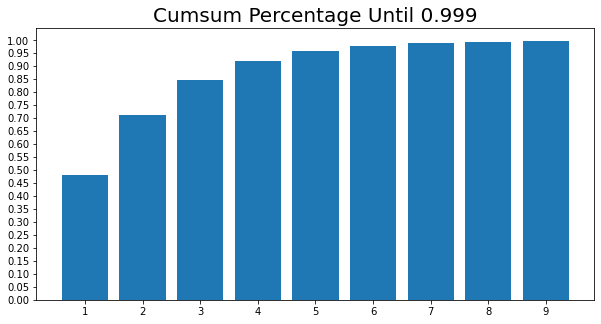

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999)
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### Session Time
Time column의 형태를 변환해 데이터의 기간을 파악하고 데이터를 어느 정도 활용할 지 결정한다.

In [15]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [16]:
print(dt.datetime.utcfromtimestamp(oldest).strftime('%Y-%m-%d %H:%M:%S'))
print(dt.datetime.utcfromtimestamp(latest).strftime('%Y-%m-%d %H:%M:%S'))

2000-04-25 23:05:32
2003-02-28 17:49:50


In [17]:
# 최근 3년 데이터 수
print(f"3년 데이터: {len(data[data['Time'] > latest - (86400*365*3)])}")
# 최근 2년 데이터 수
print(f"2년 데이터: {len(data[data['Time'] > latest - (86400*365*2)])}")
# 최근 1년 데이터 수
print(f"1년 데이터: {len(data[data['Time'] > latest - (86400*365*1)])}")

3년 데이터: 1000209
2년 데이터: 69349
1년 데이터: 21704


데이터가 전반적으로 초반에 다수 몰려있는 것을 알 수 있었다. 따라서 데이터를 활용하는 데 있어서 3년 치의 데이터를 모두 활용해보도록 하겠다.

### Data Cleansing
최소 한 개를 초과해 클릭했을 때 다음 클릭을 예측하기 위해 길이가 1인 세션은 제거한다.
적게 클릭된 아이템의 경우도 성능에 불필요한 영향을 끼칠 수 있기 때문에 제거한다.

In [18]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있음
# 이를 위해 반복문을 통해 지속적으로 제거
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [19]:
data = cleanse_recursive(session_df, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time,SessionId
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
7,1,2804,5,978300719,5
8,1,1207,4,978300719,5
...,...,...,...,...,...
1000189,6040,3362,4,997453796,471145
1000190,6040,3421,3,997453909,471146
1000191,6040,1258,4,997453909,471146
1000205,6040,1921,4,997454464,471160


### Train, Valid, Test set split
기간을 기준으로 세 세트를 분리한다. 마지막 100일을 test set으로, 그 전의 100일을 validation set으로 분리한다.

In [20]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - (86400*n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - (86400*n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [21]:
tr, test = split_by_date(data, n_days=100)
tr, val = split_by_date(tr, n_days=100)

In [22]:
# data에 대한 정보
def stats_info(data: pd.DataFrame, status: str):
    first_time = dt.datetime.utcfromtimestamp(data["Time"].min()).strftime('%Y-%m-%d %H:%M:%S')
    last_time = dt.datetime.utcfromtimestamp(data["Time"].max()).strftime('%Y-%m-%d %H:%M:%S')
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {first_time}\n'
          f'\t Last Time : {last_time}\n')

In [23]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 768326
	 Sessions: 6037
	 Items: 3333
	 First Time : 2000-04-25 23:05:54
	 Last Time : 2002-08-11 14:28:02

* valid Set Stats Info
	 Events: 2557
	 Sessions: 126
	 Items: 1337
	 First Time : 2002-08-14 07:10:28
	 Last Time : 2002-11-20 16:38:40

* test Set Stats Info
	 Events: 2352
	 Sessions: 122
	 Items: 1268
	 First Time : 2002-11-21 01:02:06
	 Last Time : 2003-02-28 17:49:08



In [24]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [25]:
# 전처리가 완료된 데이터를 저장
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Session Dataset
데이터가 주어졌을 때 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 생성한다.

In [26]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [27]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
1,1,1270,5,978300055,1,0
2,1,1721,4,978300055,1,1
3,1,1022,5,978300055,1,2
7,1,2804,5,978300719,5,3
8,1,1207,4,978300719,5,4
9,1,1193,5,978300760,6,5
10,1,720,3,978300760,6,6
11,1,260,4,978300760,6,7
19,1,1035,5,978301753,14,8
20,1,1962,4,978301753,14,9


In [28]:
tr_dataset.click_offsets

array([     0,      3,      5, ..., 768322, 768324, 768326], dtype=int32)

In [29]:
tr_dataset.session_idx

array([     0,      1,      2, ..., 242952, 242953, 242954])

### Session Data Loader
Session Dataset 객체를 받아 Session-Parallel mini-batch를 생성한는 클래스를 선언한다.

In [30]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옴
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옴
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옴
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가할 것
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줌
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치. start와 한 칸 차이난다는 것은 session이 끝났다는 의미. mask에 기록할 것.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌 것
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 참고한 것.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록
        return start, end, mask, last_session, finished

In [31]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
1,1,1270,5,978300055,1,0
2,1,1721,4,978300055,1,1
3,1,1022,5,978300055,1,2
7,1,2804,5,978300719,5,3
8,1,1207,4,978300719,5,4
9,1,1193,5,978300760,6,5
10,1,720,3,978300760,6,6
11,1,260,4,978300760,6,7
19,1,1035,5,978301753,14,8
20,1,1962,4,978301753,14,9


In [32]:
iter_ex = iter(tr_data_loader)

In [33]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 3 5 8]
Label Item Idx are :       [1 4 6 9]
Previous Masked Input Idx are []


### Evaluation Metric
평가를 위해 RR과 Recall@k를 사용할 것이며 이를 계산하는 함수를 생성한다.

In [34]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [36]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args1 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [37]:
model1 = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 1, 3333)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    507750    
_________________________________________________________________
dropout (Dropout)            (128, 50)                 0         
_________________________________________________________________
dense (Dense)                (128, 3333)               169983    
Total params: 677,733
Trainable params: 677,733
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [38]:
# train 셋으로 학습하면서 valid 셋으로 검증
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옴
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옴
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 순회하면서 parameter를 초기화
        hidden_states[elt, :] = 0 
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드이기 때문에 mrr, recall을 구하는 라인이 존재                                             
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [39]:
train_model(model1, args1)

Evaluation:  92%|█████████▏| 11/12 [00:06<00:00,  1.67it/s]


	 - Recall@20 epoch 1: 0.095170
	 - MRR@20    epoch 1: 0.028454



Evaluation:  92%|█████████▏| 11/12 [00:05<00:00,  1.84it/s]


	 - Recall@20 epoch 2: 0.163352
	 - MRR@20    epoch 2: 0.055654



Evaluation:  92%|█████████▏| 11/12 [00:05<00:00,  1.88it/s]


	 - Recall@20 epoch 3: 0.179688
	 - MRR@20    epoch 3: 0.061015



Evaluation:  92%|█████████▏| 11/12 [00:05<00:00,  1.87it/s]


	 - Recall@20 epoch 4: 0.186080
	 - MRR@20    epoch 4: 0.063781



Evaluation:  92%|█████████▏| 11/12 [00:05<00:00,  1.89it/s]


	 - Recall@20 epoch 5: 0.191051
	 - MRR@20    epoch 5: 0.065628



Evaluation:  92%|█████████▏| 11/12 [00:05<00:00,  1.88it/s]


	 - Recall@20 epoch 6: 0.191761
	 - MRR@20    epoch 6: 0.065711



Evaluation:  92%|█████████▏| 11/12 [00:05<00:00,  1.90it/s]


	 - Recall@20 epoch 7: 0.193892
	 - MRR@20    epoch 7: 0.065591



Evaluation:  92%|█████████▏| 11/12 [00:05<00:00,  1.88it/s]


	 - Recall@20 epoch 8: 0.192472
	 - MRR@20    epoch 8: 0.065534



Evaluation:  92%|█████████▏| 11/12 [00:05<00:00,  1.91it/s]


	 - Recall@20 epoch 9: 0.195312
	 - MRR@20    epoch 9: 0.066338



Evaluation:  92%|█████████▏| 11/12 [00:05<00:00,  1.92it/s]

	 - Recall@20 epoch 10: 0.193892
	 - MRR@20    epoch 10: 0.066053



### Model Test

In [40]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model1, args1, test)

Evaluation:  91%|█████████ | 10/11 [00:05<00:00,  1.94it/s]

	 - Recall@20: 0.254688
	 - MRR@20: 0.096788



### 성능 비교
1. data cleansing을 진행하지 않은 상태로 모델을 학습시켜 보도록 하겠다.

In [41]:
tr, test = split_by_date(session_df, n_days=100)
tr, val = split_by_date(tr, n_days=100)

In [42]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 989923
	 Sessions: 6039
	 Items: 3702
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-08-12 13:53:29

* valid Set Stats Info
	 Events: 5209
	 Sessions: 245
	 Items: 1949
	 First Time : 2002-08-13 00:40:06
	 Last Time : 2002-11-20 16:38:40

* test Set Stats Info
	 Events: 5073
	 Sessions: 254
	 Items: 1893
	 First Time : 2002-11-20 20:30:02
	 Last Time : 2003-02-28 17:49:50



In [43]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [44]:
# 전처리가 완료된 데이터를 저장
save_path = data_path / 'processed2'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl2')
val.to_pickle(save_path / 'valid.pkl2')
test.to_pickle(save_path / 'test.pkl2')

In [45]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
0,1,3186,4,978300019,0,0
1,1,1270,5,978300055,1,1
2,1,1721,4,978300055,1,2
3,1,1022,5,978300055,1,3
4,1,2340,3,978300103,2,4
5,1,1836,5,978300172,3,5
6,1,3408,4,978300275,4,6
7,1,2804,5,978300719,5,7
8,1,1207,4,978300719,5,8
9,1,1193,5,978300760,6,9


In [46]:
tr_dataset.click_offsets

array([     0,      1,      4, ..., 989921, 989922, 989923], dtype=int32)

In [47]:
tr_dataset.session_idx

array([     0,      1,      2, ..., 463928, 463929, 463930])

In [48]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
0,1,3186,4,978300019,0,0
1,1,1270,5,978300055,1,1
2,1,1721,4,978300055,1,2
3,1,1022,5,978300055,1,3
4,1,2340,3,978300103,2,4
5,1,1836,5,978300172,3,5
6,1,3408,4,978300275,4,6
7,1,2804,5,978300719,5,7
8,1,1207,4,978300719,5,8
9,1,1193,5,978300760,6,9


In [49]:
iter_ex = iter(tr_data_loader)

In [50]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [19  1  7  9]
Label Item Idx are :       [20  2  8 10]
Previous Masked Input Idx are [0]


In [51]:
args2 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [52]:
model2 = create_model(args2)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3702)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    563100    
_________________________________________________________________
dropout_1 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (128, 3702)               188802    
Total params: 751,902
Trainable params: 751,902
Non-trainable params: 0
_________________________________________________________________


In [53]:
train_model(model2, args2)

Evaluation:  92%|█████████▏| 11/12 [00:06<00:00,  1.75it/s]


	 - Recall@20 epoch 1: 0.134943
	 - MRR@20    epoch 1: 0.041979



Evaluation:  92%|█████████▏| 11/12 [00:05<00:00,  1.91it/s]


	 - Recall@20 epoch 2: 0.174006
	 - MRR@20    epoch 2: 0.058987



Evaluation:  92%|█████████▏| 11/12 [00:05<00:00,  1.90it/s]


	 - Recall@20 epoch 3: 0.186080
	 - MRR@20    epoch 3: 0.064407



Evaluation:  92%|█████████▏| 11/12 [00:05<00:00,  1.94it/s]


	 - Recall@20 epoch 4: 0.193892
	 - MRR@20    epoch 4: 0.067180



Evaluation:  92%|█████████▏| 11/12 [00:05<00:00,  1.93it/s]


	 - Recall@20 epoch 5: 0.198153
	 - MRR@20    epoch 5: 0.071695



Evaluation:  92%|█████████▏| 11/12 [00:05<00:00,  1.93it/s]


	 - Recall@20 epoch 6: 0.196023
	 - MRR@20    epoch 6: 0.070183



Evaluation:  92%|█████████▏| 11/12 [00:05<00:00,  1.91it/s]


	 - Recall@20 epoch 7: 0.199574
	 - MRR@20    epoch 7: 0.072483



Evaluation:  92%|█████████▏| 11/12 [00:05<00:00,  1.90it/s]


	 - Recall@20 epoch 8: 0.200994
	 - MRR@20    epoch 8: 0.071419



Evaluation:  92%|█████████▏| 11/12 [00:05<00:00,  1.90it/s]


	 - Recall@20 epoch 9: 0.200284
	 - MRR@20    epoch 9: 0.071622



Evaluation:  92%|█████████▏| 11/12 [00:05<00:00,  1.90it/s]

	 - Recall@20 epoch 10: 0.203125
	 - MRR@20    epoch 10: 0.072734



In [54]:
test_model(model2, args2, test)

Evaluation:  91%|█████████ | 10/11 [00:05<00:00,  1.99it/s]

	 - Recall@20: 0.266406
	 - MRR@20: 0.104455



2. 하이퍼파라미터 변경
batch size를 128에서 64로 변경한다. drop rate는 0.2로 변경한다.

In [55]:
args3 = Args(tr, val, test, batch_size=64, hsz=25, drop_rate=0.2, lr=0.001, epochs=10, k=20)

In [56]:
model3 = create_model(args3)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, 1, 3702)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 25), (64, 25)]      279675    
_________________________________________________________________
dropout_2 (Dropout)          (64, 25)                  0         
_________________________________________________________________
dense_2 (Dense)              (64, 3702)                96252     
Total params: 375,927
Trainable params: 375,927
Non-trainable params: 0
_________________________________________________________________


In [57]:
train_model(model3, args3)

Evaluation:  96%|█████████▌| 23/24 [00:06<00:00,  3.33it/s]


	 - Recall@20 epoch 1: 0.101902
	 - MRR@20    epoch 1: 0.027230



Evaluation:  96%|█████████▌| 23/24 [00:06<00:00,  3.54it/s]


	 - Recall@20 epoch 2: 0.159647
	 - MRR@20    epoch 2: 0.049932



Evaluation:  96%|█████████▌| 23/24 [00:06<00:00,  3.59it/s]


	 - Recall@20 epoch 3: 0.170516
	 - MRR@20    epoch 3: 0.056156



Evaluation:  96%|█████████▌| 23/24 [00:06<00:00,  3.57it/s]


	 - Recall@20 epoch 4: 0.177989
	 - MRR@20    epoch 4: 0.059892



Evaluation:  96%|█████████▌| 23/24 [00:06<00:00,  3.57it/s]


	 - Recall@20 epoch 5: 0.183424
	 - MRR@20    epoch 5: 0.059746



Evaluation:  96%|█████████▌| 23/24 [00:06<00:00,  3.59it/s]


	 - Recall@20 epoch 6: 0.186821
	 - MRR@20    epoch 6: 0.063573



Evaluation:  96%|█████████▌| 23/24 [00:06<00:00,  3.62it/s]


	 - Recall@20 epoch 7: 0.188179
	 - MRR@20    epoch 7: 0.064225



Evaluation:  96%|█████████▌| 23/24 [00:06<00:00,  3.56it/s]


	 - Recall@20 epoch 8: 0.190217
	 - MRR@20    epoch 8: 0.063031



Evaluation:  96%|█████████▌| 23/24 [00:06<00:00,  3.55it/s]


	 - Recall@20 epoch 9: 0.193614
	 - MRR@20    epoch 9: 0.063617



Evaluation:  96%|█████████▌| 23/24 [00:06<00:00,  3.57it/s]

	 - Recall@20 epoch 10: 0.191576
	 - MRR@20    epoch 10: 0.063191



In [58]:
test_model(model3, args3, test)

Evaluation:  96%|█████████▌| 22/23 [00:05<00:00,  3.76it/s]

	 - Recall@20: 0.260653
	 - MRR@20: 0.098346



3. 세션 범위 재설정
최근 1년치의 데이터만 활용한다.

In [59]:
data2 = data[data['Time'] > latest - (86400*365*1)]

In [60]:
data2

,UserId,ItemId,Rating,Time,SessionId
5333,36,1387,5,1015904819,2791
5334,36,1201,4,1015904819,2791
5336,36,2167,5,1015904905,2793
5337,36,2951,4,1015904905,2793
5338,36,2115,5,1015904905,2793
...,...,...,...,...,...
992778,5996,2375,3,1020111221,468252
992779,5996,2616,3,1020111375,468253
992780,5996,3707,5,1020111375,468253
992781,5996,781,5,1020111524,468254


In [61]:
tr, test = split_by_date(data2, n_days=50)
tr, val = split_by_date(tr, n_days=50)

In [62]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 8065
	 Sessions: 308
	 Items: 2192
	 First Time : 2002-02-28 19:21:39
	 Last Time : 2002-11-20 00:47:58

* valid Set Stats Info
	 Events: 972
	 Sessions: 78
	 Items: 640
	 First Time : 2002-11-20 16:24:13
	 Last Time : 2003-01-09 00:54:13

* test Set Stats Info
	 Events: 1208
	 Sessions: 54
	 Items: 825
	 First Time : 2003-01-10 13:54:07
	 Last Time : 2003-02-28 17:49:08



In [63]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [64]:
# 전처리가 완료된 데이터를 저장
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Session Dataset

In [65]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
5333,36,1387,5,1015904819,2791,0
5334,36,1201,4,1015904819,2791,1
5336,36,2167,5,1015904905,2793,2
5337,36,2951,4,1015904905,2793,3
5338,36,2115,5,1015904905,2793,4
5339,36,1912,5,1015904924,2794,5
5340,36,2662,3,1015904924,2794,6
5346,36,3142,4,1015905144,2800,7
5347,36,556,5,1015905144,2800,8
9754,65,2628,4,1022468310,4875,9


In [66]:
tr_dataset.click_offsets

array([   0,    2,    5, ..., 8061, 8063, 8065], dtype=int32)

In [67]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 2898, 2899, 2900])

### Session Data Loader

In [68]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
5333,36,1387,5,1015904819,2791,0
5334,36,1201,4,1015904819,2791,1
5336,36,2167,5,1015904905,2793,2
5337,36,2951,4,1015904905,2793,3
5338,36,2115,5,1015904905,2793,4
5339,36,1912,5,1015904924,2794,5
5340,36,2662,3,1015904924,2794,6
5346,36,3142,4,1015905144,2800,7
5347,36,556,5,1015905144,2800,8
9754,65,2628,4,1022468310,4875,9


In [69]:
iter_ex = iter(tr_data_loader)

In [70]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 2 5 7]
Label Item Idx are :       [1 3 6 8]
Previous Masked Input Idx are []


In [71]:
args4 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [72]:
model4 = create_model(args4)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(128, 1, 2192)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    336600    
_________________________________________________________________
dropout_3 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_3 (Dense)              (128, 2192)               111792    
Total params: 448,392
Trainable params: 448,392
Non-trainable params: 0
_________________________________________________________________


In [73]:
train_model(model4, args4)

Evaluation:  75%|███████▌  | 3/4 [00:01<00:00,  1.57it/s]


	 - Recall@20 epoch 1: 0.067708
	 - MRR@20    epoch 1: 0.016473



Evaluation:  75%|███████▌  | 3/4 [00:01<00:00,  1.78it/s]


	 - Recall@20 epoch 2: 0.059896
	 - MRR@20    epoch 2: 0.013440



Evaluation:  75%|███████▌  | 3/4 [00:01<00:00,  1.75it/s]


	 - Recall@20 epoch 3: 0.052083
	 - MRR@20    epoch 3: 0.011369



Evaluation:  75%|███████▌  | 3/4 [00:01<00:00,  1.73it/s]


	 - Recall@20 epoch 4: 0.041667
	 - MRR@20    epoch 4: 0.010406



Evaluation:  75%|███████▌  | 3/4 [00:01<00:00,  1.80it/s]


	 - Recall@20 epoch 5: 0.044271
	 - MRR@20    epoch 5: 0.009390



Evaluation:  75%|███████▌  | 3/4 [00:01<00:00,  1.68it/s]


	 - Recall@20 epoch 6: 0.044271
	 - MRR@20    epoch 6: 0.009104



Evaluation:  75%|███████▌  | 3/4 [00:01<00:00,  1.74it/s]


	 - Recall@20 epoch 7: 0.046875
	 - MRR@20    epoch 7: 0.009027



Evaluation:  75%|███████▌  | 3/4 [00:01<00:00,  1.78it/s]


	 - Recall@20 epoch 8: 0.046875
	 - MRR@20    epoch 8: 0.008919



Evaluation:  75%|███████▌  | 3/4 [00:01<00:00,  1.77it/s]


	 - Recall@20 epoch 9: 0.049479
	 - MRR@20    epoch 9: 0.009024



Evaluation:  75%|███████▌  | 3/4 [00:01<00:00,  1.74it/s]

	 - Recall@20 epoch 10: 0.044271
	 - MRR@20    epoch 10: 0.008914



In [74]:
test_model(model4, args4, test)

Evaluation: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

	 - Recall@20: 0.051562
	 - MRR@20: 0.009439



## 결과분석

총 네 가지 모델을 비교해본 결과를 정리하면 다음과 같다.

||Recall|MRR|
|:-:|:-:|:-:|
|Model1|0.254688|0.096788|
|Model2|0.266406|0.104455|
|Model3|0.260653|0.098346|
|Model4|0.051562|0.009439|

Data cleansing을 진행하지 않은 경우(Model2)와 진행한 경우(Model1)를 비교했을 때 약소한 차이지만 진행하지 않은 경우가 성능이 좋았다. 단순히 모델의 하이퍼파라미터 중 batch size를 변경했을 경우(Model3) 또한 기본 모델(Model1)에 비해 성능이 근소한 차이로 향상되었다. 반면 Session Time의 데이터 수를 최근 1년 것만을 활용한 경우(Model4) 성능이 크게 떨어진 것을 확인할 수 있었다.